# Úvod

Sluneční skvrny jsou dočasné jevy ve fotosféře Slunce, které se projevují jako skvrny tmavší než okolní oblasti. Jedná se o oblasti se sníženou povrchovou teplotou způsobenou koncentrací toku magnetického pole, které brání konvekci. Sluneční skvrny se obvykle objevují v párech opačné magnetické polarity. Jejich počet se mění v závislosti na přibližně 11letém slunečním cyklu.

[Odkaz na Wikipedii](https://en.wikipedia.org/wiki/Sunspot) a [odkaz na Kaggle](https://www.kaggle.com/datasets/robervalt/sunspots).

# Načtení všech knihoven

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("CPU")

GPU: NVIDIA GeForce RTX 2070


# Načtení dat a první pohled

In [3]:
df = pd.read_csv("datasets/Sunspots.csv")

In [4]:
df.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [5]:
df.shape

(3265, 3)

In [6]:
int(df.duplicated().sum())

0

In [7]:
df.dtypes

Unnamed: 0                             int64
Date                                  object
Monthly Mean Total Sunspot Number    float64
dtype: object

In [8]:
df.isna().sum()

Unnamed: 0                           0
Date                                 0
Monthly Mean Total Sunspot Number    0
dtype: int64

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,3265.0,1632.000000,942.668641,0.0,816.0,1632.0,2448.0,3264.0
Monthly Mean Total Sunspot Number,3265.0,81.778775,67.889277,0.0,23.9,67.2,122.5,398.2


# Úprava dat

In [10]:
df.drop(columns="Unnamed: 0", inplace=True)

In [11]:
df["Date"] = pd.to_datetime(df["Date"])

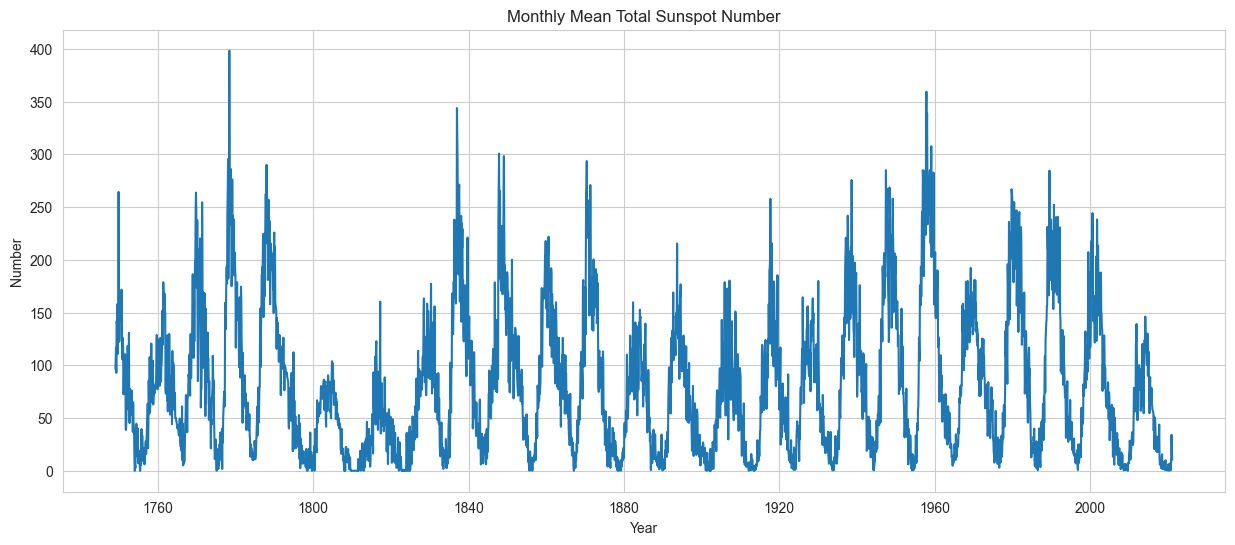

In [12]:
plt.figure(figsize=(15, 6))
plt.plot(df["Date"], df["Monthly Mean Total Sunspot Number"])
plt.xlabel("Year")
plt.ylabel("Number")
plt.title("Monthly Mean Total Sunspot Number")
plt.show()

In [13]:
df = df.set_index("Date")

## Škálování dat

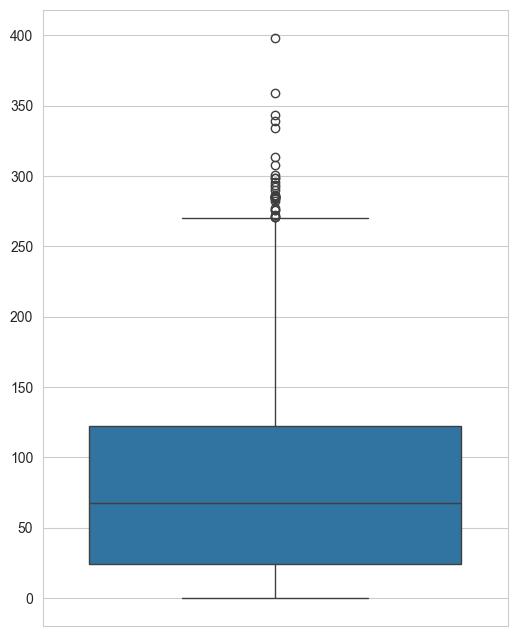

In [14]:
plt.figure(figsize=(6, 8))
sns.boxplot(data=df)
plt.xticks([])
plt.show()

Jelikož máme několik outlierů, použijeme `RobustScaler`, který je robustnější vůči outlierům.

In [15]:
robust_scaler = RobustScaler()

In [16]:
df_scaled = pd.DataFrame(robust_scaler.fit_transform(df), columns=df.columns)

In [17]:
display(df.head())
display(df_scaled.head())

,Monthly Mean Total Sunspot Number
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7


,Monthly Mean Total Sunspot Number
0,0.299189
1,0.376268
2,0.502028
3,0.259635
4,0.755578


## Trénovací a testovací data

In [18]:
split_ratio = 0.8
split_index = int(split_ratio * len(df_scaled))

In [19]:
train_data = df_scaled.iloc[:split_index]
test_data = df_scaled.iloc[split_index:]

In [20]:
print(f"Train data shape: {train_data.shape}\nTest data shape: {test_data.shape}")

Train data shape: (2612, 1)
Test data shape: (653, 1)


### Posunutí dat

Tato funkce posune data o zadaný počet měsíců. Takto můžeme vytvořit nové sloupce, které budou obsahovat data z minulosti.

In [21]:
def shift_dataset(data, window_size):
    df_new = data.copy()

    for i in range(1, window_size + 1):
        df_new[f"t-{i}"] = df_new["Monthly Mean Total Sunspot Number"].shift(i)
    df_new.dropna(inplace=True)
    return df_new

# Trénování modelu

## Funkce pro výpočet metrik

In [22]:
def compute_metrics(y_true, y_pred):
    def symetric_mean_absolute_percentage_error(y_true, y_pred):
        return np.mean(np.abs((y_pred - y_true) / ((np.abs(y_true) + np.abs(y_pred)) / 2.0))) * 100

    if isinstance(y_true, torch.Tensor):
        y_true = y_true.cpu().numpy()
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.cpu().numpy()

    metrics = {
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'SMAPE': symetric_mean_absolute_percentage_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }
    return pd.DataFrame([metrics], index=['metrics'])

## Funkce pro trénování modelu

(P.S. zobrazení grafu je trochu nešikovné)

In [23]:
def train_model(model, criterion, optimizer, num_epochs, train_loader, test_loader, device, save_path):
    model.to(device)
    best_loss = float('inf')
    best_model_wts = None
    best_metrics = None
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device).unsqueeze(1)  # Reshape y to match y_pred
            optimizer.zero_grad()
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        model.eval()
        running_val_loss = 0.0
        y_true = []
        y_pred = []
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device).unsqueeze(1)  # Reshape y to match y_pred
                y_true.append(y)
                y_pred.append(model(x))
                val_loss = criterion(y_pred[-1], y)
                running_val_loss += val_loss.item()

        y_true = torch.cat(y_true)
        y_pred = torch.cat(y_pred)
        metrics = compute_metrics(y_true, y_pred)
        test_loss = running_val_loss / len(test_loader)
        val_losses.append(test_loss)

        if test_loss < best_loss:
            best_loss = test_loss
            best_model_wts = model.state_dict()
            best_metrics = metrics

        print(
            f"Epoch: {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Val Loss: {test_loss:.4f}, Metrics: {metrics}")

    # Save the best model and metrics
    torch.save({
        'model_state_dict': best_model_wts,
        'best_loss': best_loss,
        'best_metrics': best_metrics
    }, save_path)

    # Plot the training and validation loss
    plt.figure(figsize=(15, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# MLP

In [24]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

Tento model je vícevrstvá perceptronová (MLP) síť se dvěma skrytými vrstvami. Používá **ReLU** aktivaci a dropout (0.2) pro regularizaci. Struktura:

- **Vstup**: `input_size`
- **Skrytá vrstva 1**: `hidden_size1` (ReLU, dropout)
- **Skrytá vrstva 2**: `hidden_size2` (ReLU, dropout)
- **Výstup**: `output_size`

Používá `torch.nn.Linear` pro lineární transformace a `torch.nn.Dropout` pro snížení přeučení.



In [25]:
window_size = 12
train_data_shifted = shift_dataset(train_data, window_size)
test_data_shifted = shift_dataset(test_data, window_size)

Vybereme si `window_size` (počet měsíců) pro posunutí dat. Vytvoříme nové sloupce pro každý měsíc v minulosti. Poté odstraníme řádky s chybějícími hodnotami.

In [26]:
X_train = train_data_shifted.drop(columns="Monthly Mean Total Sunspot Number")
y_train = train_data_shifted["Monthly Mean Total Sunspot Number"]
X_test = test_data_shifted.drop(columns="Monthly Mean Total Sunspot Number")
y_test = test_data_shifted["Monthly Mean Total Sunspot Number"]

## Příprava dat pro PyTorch

In [27]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

In [28]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

In [29]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [30]:
input_size = X_train.shape[1]
hidden_size1 = 64
hidden_size2 = 32
output_size = 1

In [31]:
model = MLP(input_size, hidden_size1, hidden_size2, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Trénování modelu

Epoch: 1/100, Train Loss: 0.1526, Val Loss: 0.0667, Metrics:               MAE      MSE      RMSE      SMAPE       R2
metrics  0.199202  0.06954  0.263704  53.726017  0.86076
Epoch: 2/100, Train Loss: 0.0970, Val Loss: 0.0565, Metrics:               MAE       MSE      RMSE      SMAPE        R2
metrics  0.180441  0.058634  0.242144  50.251549  0.882597
Epoch: 3/100, Train Loss: 0.0873, Val Loss: 0.0534, Metrics:               MAE       MSE      RMSE      SMAPE        R2
metrics  0.176965  0.055227  0.235004  50.178944  0.889419
Epoch: 4/100, Train Loss: 0.0895, Val Loss: 0.0535, Metrics:               MAE     MSE      RMSE      SMAPE        R2
metrics  0.173357  0.0555  0.235585  49.043365  0.888872
Epoch: 5/100, Train Loss: 0.0815, Val Loss: 0.0521, Metrics:               MAE       MSE      RMSE      SMAPE        R2
metrics  0.169598  0.054132  0.232662  47.509605  0.891612
Epoch: 6/100, Train Loss: 0.0835, Val Loss: 0.0547, Metrics:               MAE      MSE      RMSE      SMAPE     

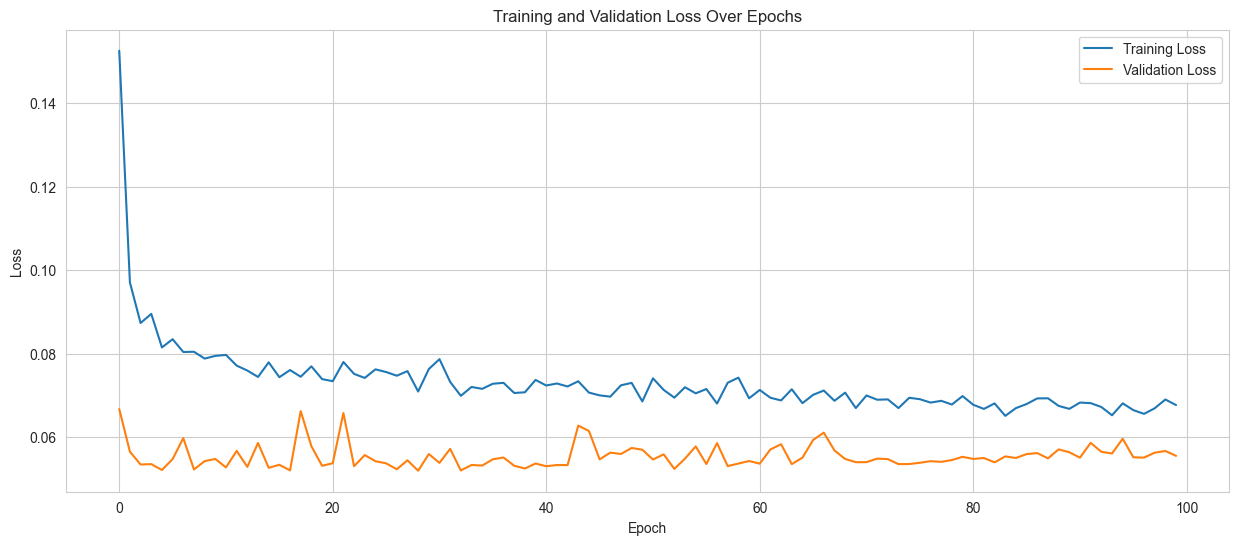

In [32]:
save_path = "models/mlp_sunspots.pth"
train_model(model, criterion, optimizer, 100, train_loader, test_loader, device, save_path)

In [33]:
checkpoint = torch.load(save_path, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

## Vyhodnocení modelu

Metrics:               MAE      MSE      RMSE     SMAPE        R2
metrics  0.172655  0.05794  0.240706  48.40007  0.883987


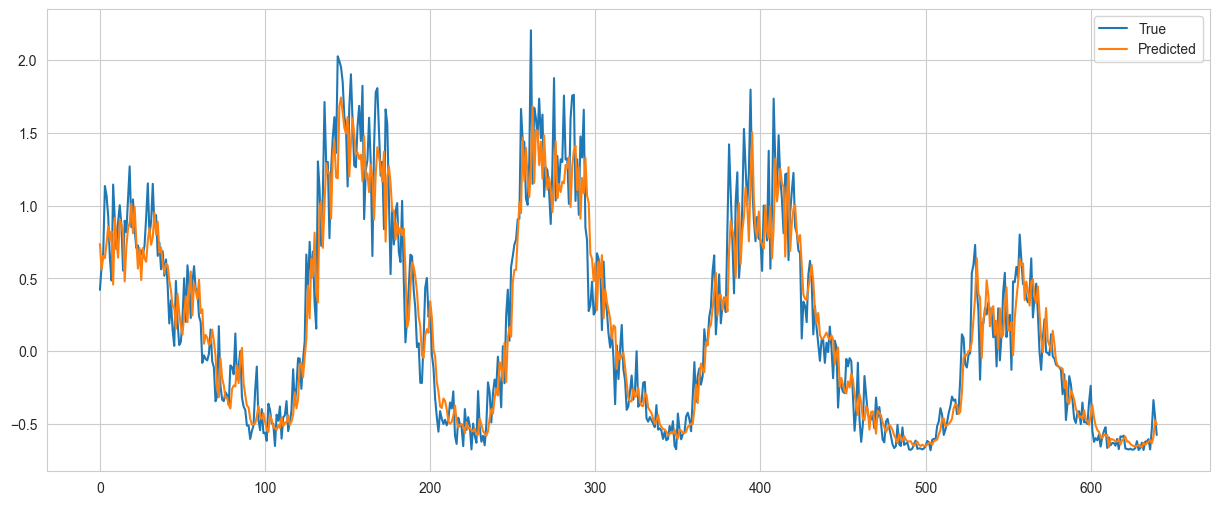

In [34]:
model.eval()
with torch.no_grad():
    y_true = []
    y_pred = []
    for x, y in test_loader:
        x, y = x.to(device), y.to(device).unsqueeze(1)  # Reshape y to match y_pred
        y_true.append(y)
        y_pred.append(model(x))
    y_true = torch.cat(y_true)
    y_pred = torch.cat(y_pred)
    metrics = compute_metrics(y_true, y_pred)
    print(f"Metrics: {metrics}")

    plt.figure(figsize=(15, 6))
    plt.plot(y_true.cpu().numpy(), label="True")
    plt.plot(y_pred.cpu().numpy(), label="Predicted")
    plt.legend()
    plt.show()

# LSTM

Tento model je složen z **tří vrstev LSTM** a plně propojené části. Používá **GELU** aktivaci pro nelinearitu. Struktura:

- **Vstup**: `input_size`, přidána sekvenční dimenze (`unsqueeze(1)`)
- **LSTM vrstvy**:
  - `lstm1`: 64 skrytých jednotek
  - `lstm2`: 64 skrytých jednotek
  - `lstm3`: 32 skrytých jednotek
- **Plně propojená část**:
  - `fc1`: 32 → 64 (GELU)
  - `fc2`: 64 → 64 (GELU)
  - `fc3`: 64 → 1 (výstup)

Model zpracovává sekvenční data a predikuje skalární výstup.

In [35]:
class LSTMModel(nn.Module):
    def __init__(self, input_size):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=64, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=64, num_layers=1, batch_first=True)
        self.lstm3 = nn.LSTM(input_size=64, hidden_size=32, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(32, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
        self.gelu = nn.GELU()

    def forward(self, x):
        x = x.unsqueeze(1)  # Add sequence dimension
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = self.gelu(self.fc1(x[:, -1, :]))
        x = self.gelu(self.fc2(x))
        x = self.fc3(x)
        return x

## Trénování modelu

Data jsou připravena pro LSTM model. Vytvoříme nový model, kritérium, optimalizér a spustíme trénování.

In [36]:
input_size = X_train.shape[1]
model = LSTMModel(input_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch: 1/100, Train Loss: 0.2780, Val Loss: 0.0880, Metrics:               MAE       MSE      RMSE      SMAPE        R2
metrics  0.237884  0.090745  0.301239  60.435463  0.818301
Epoch: 2/100, Train Loss: 0.0851, Val Loss: 0.0534, Metrics:               MAE     MSE      RMSE      SMAPE        R2
metrics  0.171585  0.0559  0.236432  46.986324  0.888071
Epoch: 3/100, Train Loss: 0.0711, Val Loss: 0.0565, Metrics:               MAE       MSE      RMSE      SMAPE        R2
metrics  0.173453  0.058789  0.242465  47.885345  0.882285
Epoch: 4/100, Train Loss: 0.0702, Val Loss: 0.0570, Metrics:               MAE       MSE      RMSE      SMAPE        R2
metrics  0.178868  0.058894  0.242681  48.554657  0.882076
Epoch: 5/100, Train Loss: 0.0685, Val Loss: 0.0516, Metrics:              MAE       MSE      RMSE      SMAPE        R2
metrics  0.17127  0.053196  0.230642  48.697235  0.893485
Epoch: 6/100, Train Loss: 0.0674, Val Loss: 0.0508, Metrics:               MAE       MSE      RMSE     SMAPE   

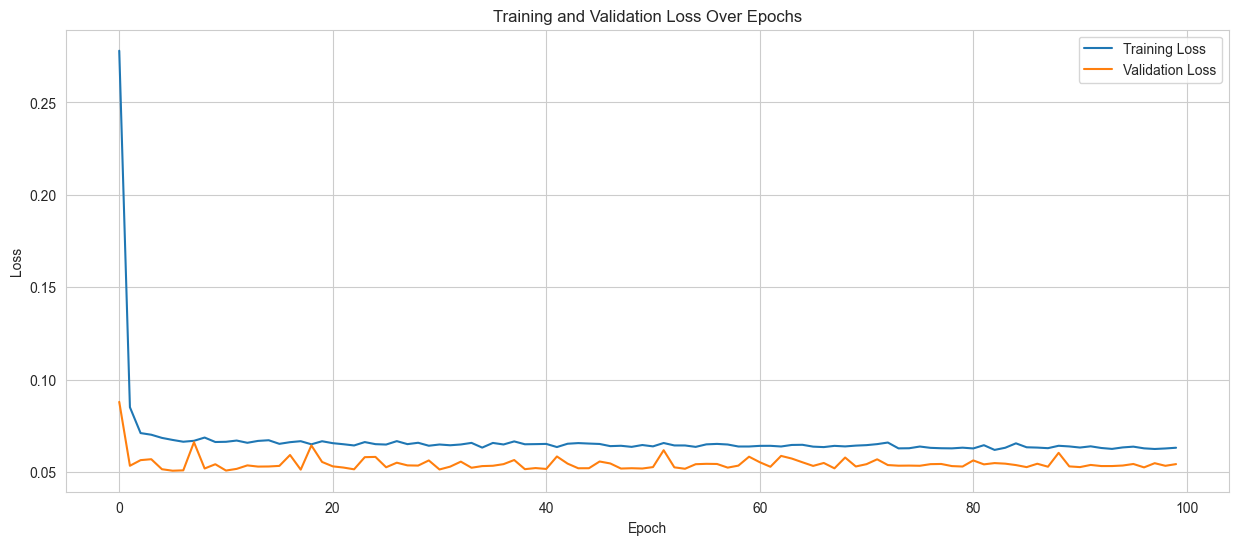

In [37]:
save_path = 'models/lstm_sunspots.pth'
train_model(model, criterion, optimizer, 100, train_loader, test_loader, device, save_path)

In [38]:
checkpoint = torch.load(save_path, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

## Vyhodnocení modelu

Metrics:               MAE      MSE      RMSE      SMAPE       R2
metrics  0.171564  0.05604  0.236728  48.640163  0.88779


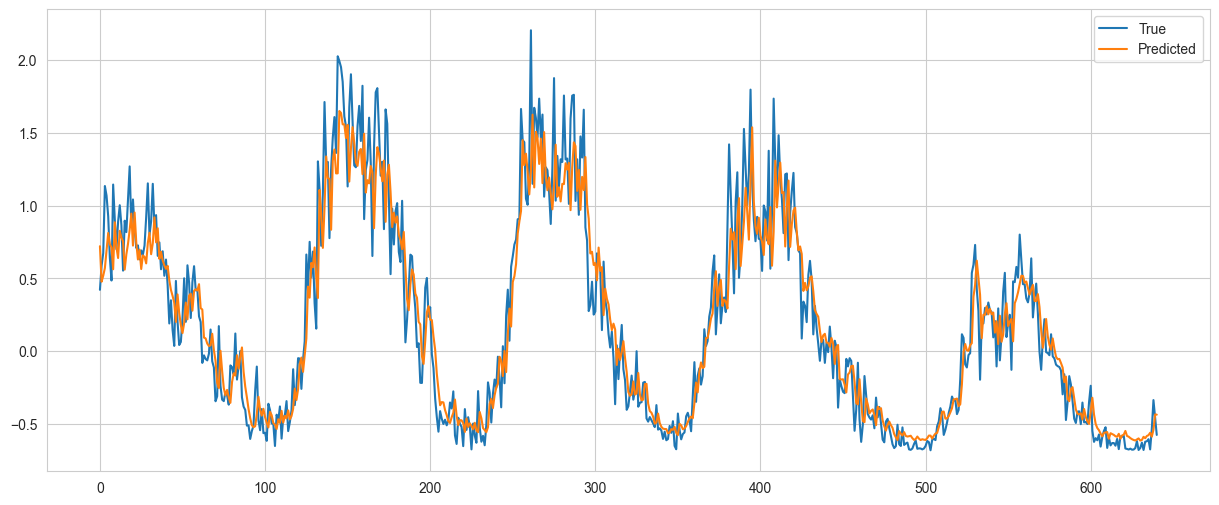

In [39]:
model.eval()
with torch.no_grad():
    y_true = []
    y_pred = []
    for x, y in test_loader:
        x, y = x.to(device), y.to(device).unsqueeze(1)  # Reshape y to match y_pred
        y_true.append(y)
        y_pred.append(model(x))
    y_true = torch.cat(y_true)
    y_pred = torch.cat(y_pred)
    metrics = compute_metrics(y_true, y_pred)
    print(f"Metrics: {metrics}")

    plt.figure(figsize=(15, 6))
    plt.plot(y_true.cpu().numpy(), label="True")
    plt.plot(y_pred.cpu().numpy(), label="Predicted")
    plt.legend()
    plt.show()